# Building and Visualizing a Decision Tree

[mahshidxyz](http://www.github.com/mahshidxyz)

July 2020

---

This study uses the **[Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)** from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**. Using the dataset, we train a classifier to predict if someone has heart disease based on their sex, age, blood pressure and a variety of other metrics. Decision trees are great for providing interpretable results. When good performance without overfitting is achieved, decision trees can be more useful than ensemble trees which are harder to interpret. In the latter, individual trees can be visualized but the model outcome is the average outcome of many trees. 




**Table of contents:**

- **[Importing and Cleaning the Data](#data-import-and-cleaning)**
    
- **[Data Formatting](#format-data)**

- **[Building Our First Tree](#build-tree)**

- **[Cost Complexity Pruning (Regularization)](#prune-tree)**

- **[Evaluating and Visualizing the Final Tree](#vis-tree)**

- **[Pros and Cons of Decision Trees](#pros-cons-tree)**


***

<a id="data-import-and-cleaning"></a>
# Data Import and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import plot_tree 
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [2]:
df = pd.read_csv('processed.cleveland.data', header=None)
# or
# df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', 
#                  header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Columns are not labeled. We need to add column names.
- **age**,
- **sex**,
- **cp**, chest pain
- **restbp**, resting blood pressure (in mm Hg)
- **chol**, serum cholesterol in mg/dl
- **fbs**, fasting blood sugar
- **restecg**, resting electrocardiographic results
- **thalach**,  maximum heart rate achieved
- **exang**, exercise induced angina
- **oldpeak**, ST depression induced by exercise relative to rest
- **slope**, the slope of the peak exercise ST segment.
- **ca**, number of major vessels (0-3) colored by fluoroscopy
- **thal**, this is short of thalium heart scan.
- **hd**, diagnosis of heart disease, the predicted attribute

In [3]:
# labeling the columns
df.columns = ['age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg', 
              'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd']

df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:
# explore the data
df.info() # or df.dtypes & df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age        303 non-null float64
sex        303 non-null float64
cp         303 non-null float64
restbp     303 non-null float64
chol       303 non-null float64
fbs        303 non-null float64
restecg    303 non-null float64
thalach    303 non-null float64
exang      303 non-null float64
oldpeak    303 non-null float64
slope      303 non-null float64
ca         303 non-null object
thal       303 non-null object
hd         303 non-null int64
dtypes: float64(11), int64(1), object(2)
memory usage: 33.2+ KB


**ca** and **thal** are expected to be numeric but are showing up as *object* type. Let's take a closer look.

In [5]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [6]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

Since scikit-learn's classification trees do not support datasets with missing values we need to either drop the missing entries or impute the missing values. Since only 6 out of 303 rows are missing values we will drop the incomplete entries.

In [7]:
# see how many rows have missing values
len(df.loc[(df['ca'] == '?') | (df['thal'] == '?')])

6

In [8]:
# rows that contain missing values
df.loc[(df['ca'] == '?') | (df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [9]:
# drop missing values
df = df.loc[(df['ca'] != '?') & (df['thal'] != '?')]

# make sure they are gone!
for col in ['ca', 'thal']:
    print(col,'values:', df[col].unique())

ca values: ['0.0' '3.0' '2.0' '1.0']
thal values: ['6.0' '3.0' '7.0']


In [10]:
# checking hd (our dependent variable) values
# value 0 means no heart disease while other values indicate some sort of hear disease
df['hd'].unique()

array([0, 2, 1, 3, 4], dtype=int64)

<a id="format-data"></a>
# Data Formatting

## Dependent and independent variables

Since we want to build a binary classifier, we will label cases with any of the 4 types of heart diseases as class 1 and keep the no heart disease case at class 0.

In [11]:
# split the data to dependent (y) and independent (X) variables
X = df.drop('hd', axis=1) 
y = df['hd']
# relabel all 4 heart diseases (y between 1 and 4) to 1 to build a binary classifier
mask_index = y>0
y[mask_index] = 1

## One-Hot Encoding

Categorical columns with more than two values should be one-hot-encoded (array of binary values). Otherwise their data will be treated as numeric which would cause category 1 to be considered closer to category 2 than 3, while we know that categories are not ordinal and should be treated independently. 
Note that unlike using dummy variables in regression, where we drop one column to insure columns are independent from each other, we should not drop any columns here.


- **age**, **Float**
- **sex** - **Category**
  - 0 = female
  - 1 = male
- **cp**, chest pain, **Category**
  - 1 = typical angina
  - 2 = atypical angina
  - 3 = non-anginal pain
  - 4 = asymptomatic
- **restbp**, resting blood pressure (in mm Hg), **Float**
- **chol**, serum cholesterol in mg/dl, **Float**
- **fbs**, fasting blood sugar, **Category**
  - 0 = >=120 mg/dl
  - 1 = <120 mg/dl
- **restecg**, resting electrocardiographic results, **Category**
  - 1 = normal
  - 2 = having ST-T wave abnormality
  - 3 = showing probable or definite left ventricular hypertrophy
- **thalach**,  maximum heart rate achieved, **Float**
- **exang**, exercise induced angina, **Category**
  - 0 = no
  - 1 = yes
- **oldpeak**, ST depression induced by exercise relative to rest. **Float**
- **slope**, the slope of the peak exercise ST segment, **Category**
  - 1 = upsloping
  - 2 = flat
  - 3 = downsloping
- **ca**, number of major vessels (0-3) colored by fluoroscopy, **Float**
- **thal**, thalium heart scan, **Category**
  - 3 = normal (no cold spots)
  - 6 = fixed defect (cold spots during rest and exercise)
  - 7 = reversible defect (when cold spots only appear during exercise)


In [12]:
# making sure the values match what we expect and no data entry error exists
for col in ['cp', 'restecg', 'slope', 'thal']:
    print(col,'values:', X[col].unique())

cp values: [ 1.  4.  3.  2.]
restecg values: [ 2.  0.  1.]
slope values: [ 3.  2.  1.]
thal values: ['6.0' '3.0' '7.0']


In [13]:
# using get_dummies() on a single column
pd.get_dummies(X, columns=['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0


In [14]:
# converting all the categorical columns
X_encoded = pd.get_dummies(X, columns=['cp', 'restecg', 'slope', 'thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


<a id="build-tree"></a>
# Building Our First Tree

The preliminary process includes splitting the data into train and test sets, creating an instance of a classifier, and visualizing the tree and confusion matrix. Without regularization, the tree would be expected to overfit to the training set and not do equally well on the test set. We will use accuracy and recall (because it is a disease and we probably want to minimize our false negative rate) as performance metrics. Other metrics such as precision, specificity, auc-roc, and auc-precision-recall may also be used depending on the application and the dataset. Auc-roc works well when we have an imbalanced datasets while auc-precision-recall does better for imbalanced datasets with few samples in the minority class (see [here](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)). In this case, our dataset is well balanced.

After building the first model and observing a large gap in performance between the test and train sets, regularization is in order.

In [15]:
# let's see how balanced our dataset is
len(y[y==1])/len(y)

0.4612794612794613

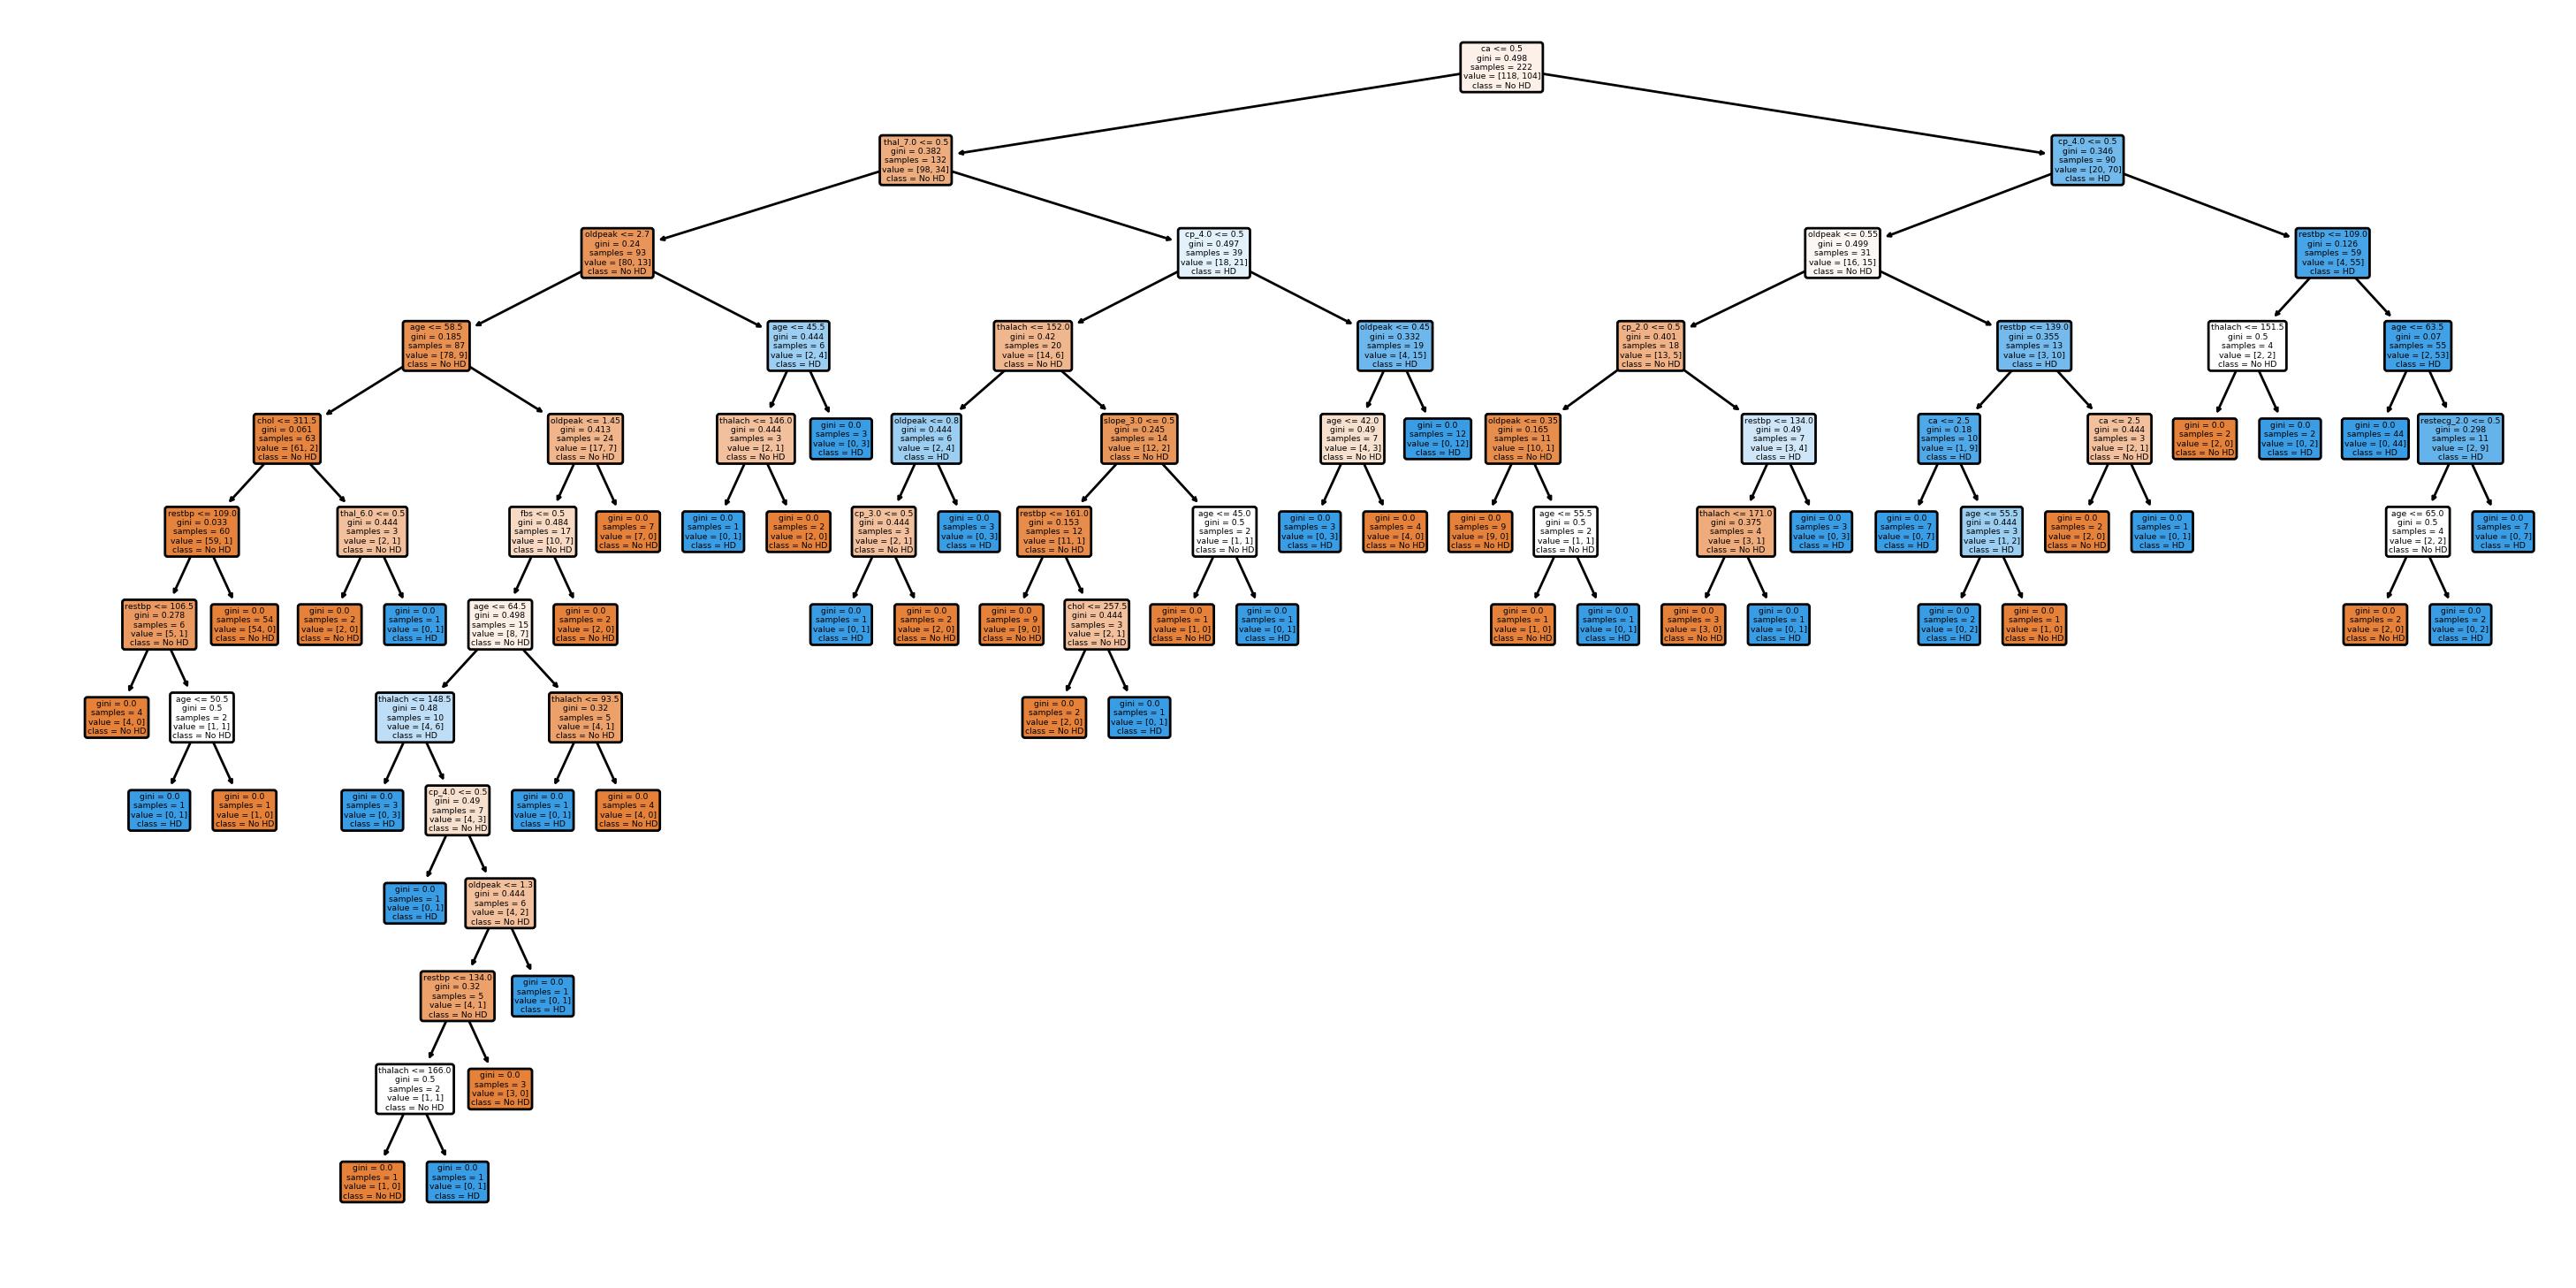

In [16]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

# create an instance of a decision tree classifier and fit it to the training set
clf_dt = DecisionTreeClassifier(random_state=15)
clf_dt = clf_dt.fit(X_train, y_train)

# visualize the preliminary tree, put the semicolon in the end to only get the image wo node info texts
plt.figure(figsize=(18, 9), dpi=200)
plot_tree(clf_dt, filled=True, rounded=True, class_names=["No HD", "HD"], feature_names=X_encoded.columns);

# Double click tree to zoom.

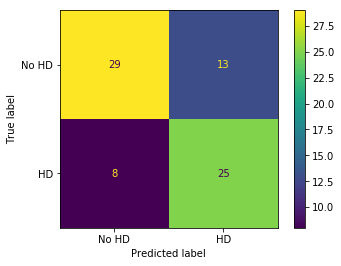

In [17]:
# confusion matrix
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["No HD", "HD"]);

In [18]:
predicted_train = clf_dt.predict(X_train)
accuracy_train = accuracy_score(y_train, predicted_train)
recall_train = recall_score(y_train, predicted_train)

predicted_test = clf_dt.predict(X_test)
accuracy_test = accuracy_score(y_test, predicted_test)
recall_test = recall_score(y_test, predicted_test)

print ('accuracy for training set:', accuracy_train)
print ('accuracy for test set:', accuracy_test)
print ('')
print ('recall for training set:', recall_train)
print ('recall for test set:', recall_test)

accuracy for training set: 1.0
accuracy for test set: 0.72

recall for training set: 1.0
recall for test set: 0.757575757576


<a id="prune-tree"></a>
# Cost Complexity Pruning (Regularization)

The idea of pruning trees is to remove some leaves to avoid overfitting. Alpha is the hyperparameter that penalizes the number of leaves (Tree score = error +  alpha * number of leaves). For a given alpha, there is a pruning level that minimizes tree score and determines the best sub-tree. For regularization, alpha needs be optimized with cross validation.

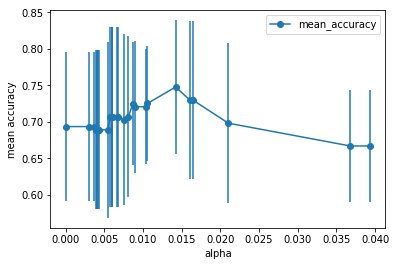

In [19]:
# cost complexity pruning 
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas # effective alphas of subtree during pruning.
ccp_alphas = ccp_alphas[:-1] # exclude the maximum value of alpha which only keeps the root node

# create a list to store the results of each fold during cross validiation
alpha_fold_values = []

# for each alpha we will run 5-fold cross validation and store the mean and std of the scores
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=15, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_fold_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

# plot accuracy vs alpha
alpha_result_df = pd.DataFrame(alpha_fold_values, columns=['alpha', 'mean_accuracy', 'std'])
alpha_result_df.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o')
plt.ylabel('mean accuracy');

In [20]:
# find the optimum value of alpha
alpha_opt = float(alpha_result_df.loc[alpha_result_df['mean_accuracy'] == alpha_result_df['mean_accuracy'].max(), 'alpha'])
alpha_result_df[alpha_result_df['mean_accuracy'] == alpha_result_df['mean_accuracy'].max()]


,alpha,mean_accuracy,std
21,0.014225,0.747778,0.091395


<a id="vis-tree"></a>
# Evaluating and Visualizing the Final Tree

Now we can use the ideal value of alpha to build a new model. We will see that, after pruning, there is a much better match between the performance metrics in the training and test sets and the model is not overfitting. 

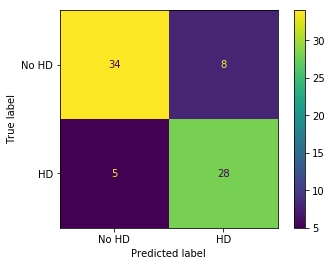

In [21]:
# use the optimal alpha to build a new classifier
clf_dt_pruned = DecisionTreeClassifier(random_state=15, ccp_alpha=alpha_opt)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train) 
plot_confusion_matrix(clf_dt_pruned, X_test, y_test, display_labels=["No HD", "HD"]);

In [22]:
# compare the metrics in the training and test set 
predicted_train = clf_dt_pruned.predict(X_train)
accuracy_train = accuracy_score(y_train, predicted_train)
recall_train = recall_score(y_train, predicted_train)

predicted_test = clf_dt_pruned.predict(X_test)
accuracy_test = accuracy_score(y_test, predicted_test)
recall_test = recall_score(y_test, predicted_test)

print ('accuracy for training set:', accuracy_train)
print ('accuracy for test set:', accuracy_test)
print ('')
print ('recall for training set:', recall_train)
print ('recall for test set:', recall_test)

accuracy for training set: 0.851351351351
accuracy for test set: 0.826666666667

recall for training set: 0.807692307692
recall for test set: 0.848484848485


### Draw the pruned tree 

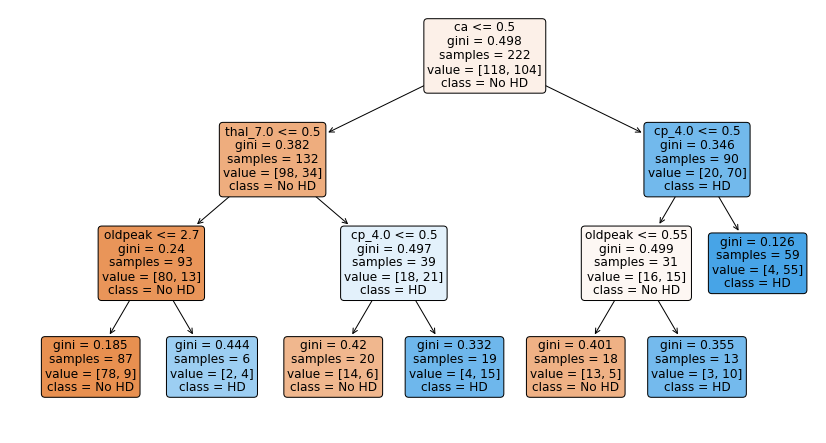

In [23]:
# draw the pruned tree
# use cell> current outputs> toggle scrolling to get the complete pic
plt.figure(figsize=(14, 7.5))
plot_tree(clf_dt_pruned, filled=True, rounded=True, class_names=["No HD", "HD"], feature_names=X_encoded.columns); 

#### How to interpret the visualization

- The first line in the nodes (except for leaf nodes) includes *variable* and the *threshold* for splitting the observations. For example, in the tree's root, ca is used to split the observations. All observations with ca <= 0.5 go to the left and all observations with ca > 0.5 go to the right.
- *gini* is the gini index/score for the node. Lowest and best value of gini score is 0 which indicates lowest impurity. For a binary classification the maximum gini score is 0.5 while for a multi-class classification it can go up to 1. A low gini in leaf nodes indicates a high quality classification. Note that there is an alternative to gini score, entropy, for which the range is always 0-1. Gini and entropy are both maximized when the classes are equally mixed in that node.
- *samples* is the number of samples from the dataset that pass through the node
- *value* is the number of samples per category at the node. Categories are in alphabetical order- [0, 1].
- *class* tells us whichever category is the majority of the samples at the node.
- The leaves are similar to the nodes, except that they do not contain a variable and threshold for splitting the observations.
- The nodes and leaves are colored by class. Each class takes the shades of one color. The the darker the shade, the lower the gini score.

### The text report of the decision tree

In [24]:
# print the tree
# note that feature_names=X_encoded.columns doesn't work here!
# you can run this without feature_names & you will get the report with columns' numerical values
r = export_text(clf_dt_pruned, feature_names=list(X_encoded))
print(r)

# interesting array where -2 represent a leaf node
# clf_dt_pruned.tree_.feature 

|--- ca <= 0.50
|   |--- thal_7.0 <= 0.50
|   |   |--- oldpeak <= 2.70
|   |   |   |--- class: 0
|   |   |--- oldpeak >  2.70
|   |   |   |--- class: 1
|   |--- thal_7.0 >  0.50
|   |   |--- cp_4.0 <= 0.50
|   |   |   |--- class: 0
|   |   |--- cp_4.0 >  0.50
|   |   |   |--- class: 1
|--- ca >  0.50
|   |--- cp_4.0 <= 0.50
|   |   |--- oldpeak <= 0.55
|   |   |   |--- class: 0
|   |   |--- oldpeak >  0.55
|   |   |   |--- class: 1
|   |--- cp_4.0 >  0.50
|   |   |--- class: 1



<a id="pros-cons-tree"></a>
# Pros and Cons of Decision Trees

credit: www.sckit-learn.org

Some advantages of decision trees are:

- Simple to understand and to interpret using boolean logic. Trees are white box models that can be visualised. In black box models (e.g. neural networks) results are not easy to interpret.

- Requires little data preparation. Other techniques often require data normalisation and missing values need to be removed. (although sklearn does support missing values for trees).

- The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.

- Able to handle both numerical and categorical data.

- Able to handle multi-output problems.

- Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.

The disadvantages of decision trees include:

- Decision-tree learners can create over-complex trees that do not generalise the data well (overfitting). Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.

- The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.

- There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems.

- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

To overcome the shortcomings of Decision Trees we need to use an ensemble learner such as Random Forest or XGBoost.